# Face Generation with DCGAN

In this notebook, I use The **Large-scale CelebFaces Attributes (CelebA) Dataset** [[1]](#ref1) to train DCGAN.  

If you are not familiar with GAN (Generative Adversarial Network), please see:

* [gan_mnist.ipynb](gan_mnist.ipynb) - GAN with a simple network
* [dcgan_mnist.ipynb](dcgan_mnist.ipynb) - DCGAN example with MNIST
* [dcgan_svhn.ipynb](dcgan_svhn.ipynb) - DCGAN example with SVHN

In this project, I generate face images based on the celebrity faces in the CelebA dataset.  The project idea is based on the **Face Generation project by Udacity** [[3]](#ref3).

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.misc import imresize
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import keras.backend as K
from keras.initializers import RandomNormal
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Loading CelebA Dataset

Download CelebA dataset from the Chinese University of Hong Kong if not already done.

In [2]:
#
# Uncomment below to download CelebA datasets (it takes some time)
#
#!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
#!unzip celeba.zip

The dataset is big so we load all the filenames and load images in batch when needed.

In [3]:
filenames = np.array(glob('img_align_celeba/*.jpg'))

Let's examine some sample images.

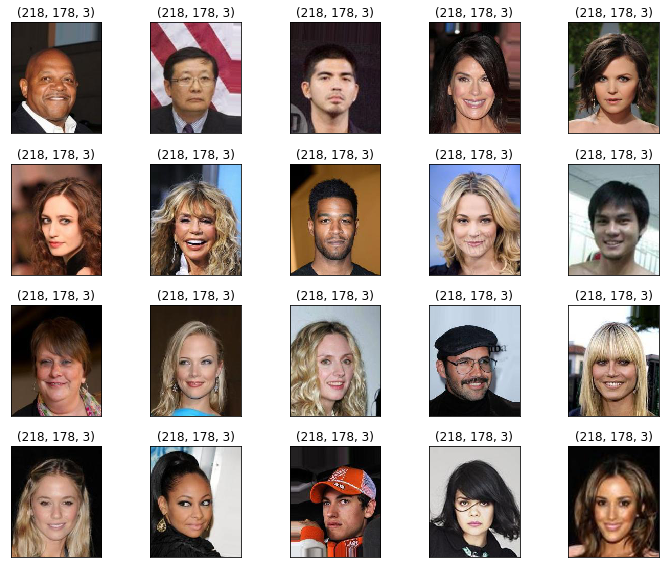

In [4]:
plt.figure(figsize=(10, 8))
for i in range(20):
    img = plt.imread(filenames[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [5]:
X_train, X_test = train_test_split(filenames, test_size=1000)

## Preprocessing and Deprocessing

Those images are pretty big.  I'll crop and resize.

In [6]:
def load_image(filename, size=(32, 32)):
    img = plt.imread(filename)
    # crop
    rows, cols = img.shape[:2]
    crop_r, crop_c = 150, 150
    start_row, start_col = (rows - crop_r) // 2, (cols - crop_c) // 2
    end_row, end_col = rows - start_row, cols - start_row
    img = img[start_row:end_row, start_col:end_col, :]
    # resize
    img = imresize(img, size)
    return img

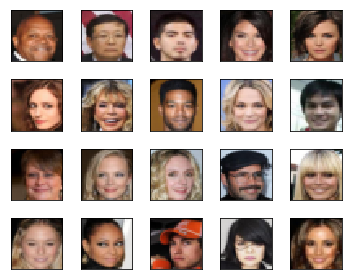

In [7]:
plt.figure(figsize=(5, 4))
for i in range(20):
    img = load_image(filenames[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

As usual, we need preprocessing and later deprocessing of the images.  

As we will see later on, the generator is using `tanh` activation, for which we need to preprocess the image data into the range between -1 and 1.

In [8]:
def preprocess(x):
    return (x/255)*2-1

def deprocess(x):
    return np.uint8((x+1)/2*255) # make sure to use uint8 type otherwise the image won't display properly

## Generator

The generator takes a latent sample (100 randomly generated numbers) and produces a color face image that should look like one from the CelebA dataset.

In [9]:
def make_generator(input_size, leaky_alpha, init_stddev):
    # generates images in (32,32,3)
    return Sequential([
        Dense(4*4*512, input_shape=(input_size,), 
              kernel_initializer=RandomNormal(stddev=init_stddev)),
        Reshape(target_shape=(4, 4, 512)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', 
                        kernel_initializer=RandomNormal(stddev=init_stddev)), # 8x8
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', 
                        kernel_initializer=RandomNormal(stddev=init_stddev)), # 16x16
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', 
                        kernel_initializer=RandomNormal(stddev=init_stddev)), # 32x32
        Activation('tanh')
    ])

## Discriminator

The discriminator is a classifier to tell if the input image is real or fake.  

In [10]:
def make_discriminator(leaky_alpha, init_stddev):
    # classifies images in (64,64,3)
    return Sequential([        
        Conv2D(64, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev),    # 16x16
               input_shape=(32, 32, 3)),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(128, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)),   # 8x8
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(256, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)),   # 4x4
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Flatten(),
        Dense(1, kernel_initializer=RandomNormal(stddev=init_stddev)),
        Activation('sigmoid')        
    ])

## DCGAN

We connect the generator and the discriminator to make a DCGAN.

In [11]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate, 
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha,
               init_std):
    # generator
    generator = make_generator(sample_size, leaky_alpha, init_std)

    # discriminator
    discriminator = make_discriminator(leaky_alpha, init_std)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training DCGAN

The below is a list of utility functions.

In [12]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable
        
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()
    
def show_images(generated_images):
    n_images = len(generated_images)
    cols = 10
    rows = n_images//cols
    
    plt.figure(figsize=(10, 8))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In the training loop, we need to load a batch of face images and use them as real images.

In [13]:
def train(
    g_learning_rate, # learning rate for the generator
    g_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate, # learning rate for the discriminator
    d_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    init_std,
    smooth=0.1,
    sample_size=100, # latent sample size (i.e. 100 random numbers)
    epochs=5,
    batch_size=128,  # train batch size
    eval_size=16,    # evaluate size
    show_details=True):

    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha,
        init_std)

    losses = []
    for e in range(epochs):
        for i in tqdm(range(len(X_train)//batch_size)):
            # real CelebA images
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            X_batch_real = np.array([preprocess(load_image(filename)) for filename in X_batch])

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)        
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval = X_test[np.random.choice(len(X_test), eval_size, replace=False)]
        X_eval_real = np.array([preprocess(load_image(filename)) for filename in X_eval])

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss = discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
            e+1, epochs, d_loss, g_loss))    
        show_images(X_eval_fake[:10])
    
    # show the result
    if show_details:
        show_losses(losses)
        show_images(generator.predict(make_latent_samples(80, sample_size)))    
    return generator

### Training 1

First, train with the hyperparameters used in the original paper [[2]](#ref2).  My network is not the same as the one in the original paper but it is a starting point for the tuning.

100%|██████████| 1574/1574 [05:32<00:00,  4.69it/s]


Epoch:   1/5 Discriminator Loss: 0.0000 Generator Loss: 12.1875


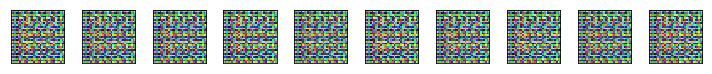

100%|██████████| 1574/1574 [05:20<00:00,  4.71it/s]


Epoch:   2/5 Discriminator Loss: 0.0003 Generator Loss: 8.0811


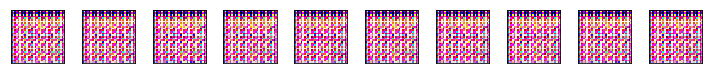

100%|██████████| 1574/1574 [05:28<00:00,  4.93it/s]


Epoch:   3/5 Discriminator Loss: 0.0055 Generator Loss: 5.2057


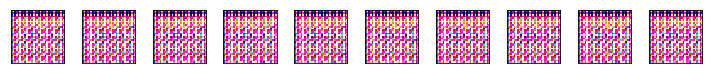

100%|██████████| 1574/1574 [05:31<00:00,  5.01it/s]


Epoch:   4/5 Discriminator Loss: 0.0616 Generator Loss: 2.8206


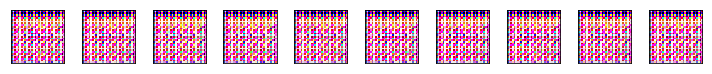

100%|██████████| 1574/1574 [05:30<00:00,  4.97it/s]


Epoch:   5/5 Discriminator Loss: 0.4009 Generator Loss: 1.1252


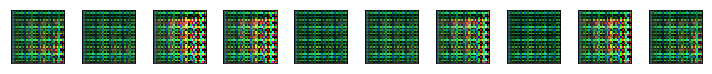

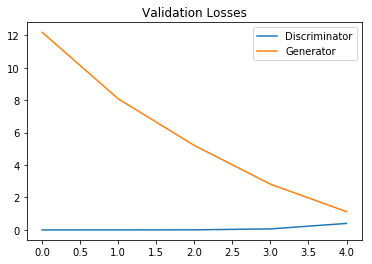

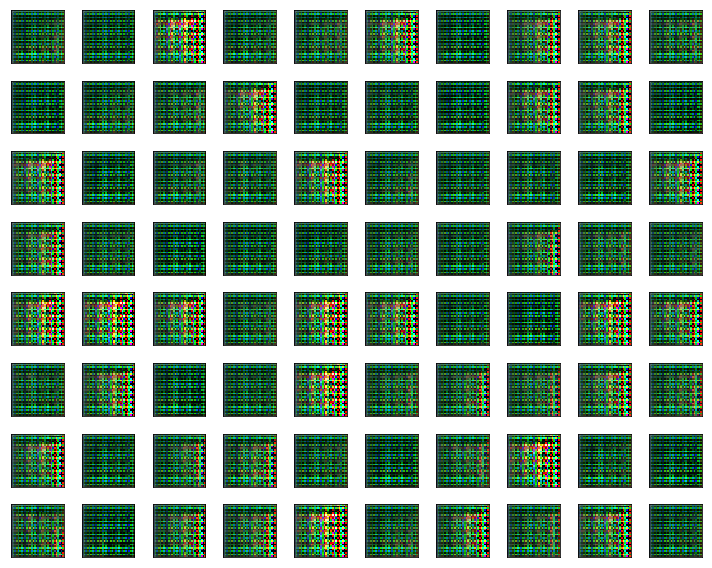

In [14]:
train(g_learning_rate=0.0002, 
      g_beta_1=0.5, 
      d_learning_rate=0.0002, 
      d_beta_1=0.5, 
      leaky_alpha=0.2, 
      init_std=0.02);

### Training 1 Observations

* No face images
* The generater loss steadily went down - did it learn to deceive the discriminator?
* The discriminator loss was relatively lower and stable.

### Training 2

I specify a smaller learning rate for the generater and a bigger learning rate for the discriminator.

100%|██████████| 1574/1574 [05:36<00:00,  4.92it/s]


Epoch:   1/5 Discriminator Loss: 0.3196 Generator Loss: 1.4361


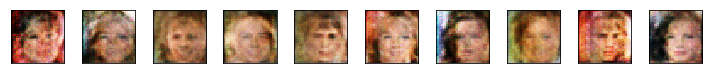

100%|██████████| 1574/1574 [05:31<00:00,  4.75it/s]


Epoch:   2/5 Discriminator Loss: 0.1796 Generator Loss: 2.0518


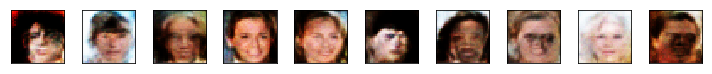

100%|██████████| 1574/1574 [05:28<00:00,  4.97it/s]


Epoch:   3/5 Discriminator Loss: 0.0373 Generator Loss: 8.1574


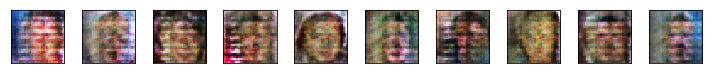

100%|██████████| 1574/1574 [05:28<00:00,  5.02it/s]


Epoch:   4/5 Discriminator Loss: 0.1251 Generator Loss: 2.2939


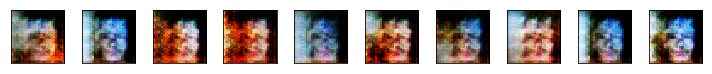

100%|██████████| 1574/1574 [05:27<00:00,  4.77it/s]


Epoch:   5/5 Discriminator Loss: 0.0952 Generator Loss: 2.7082


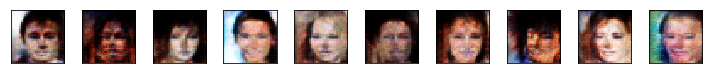

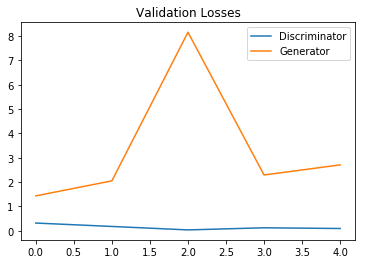

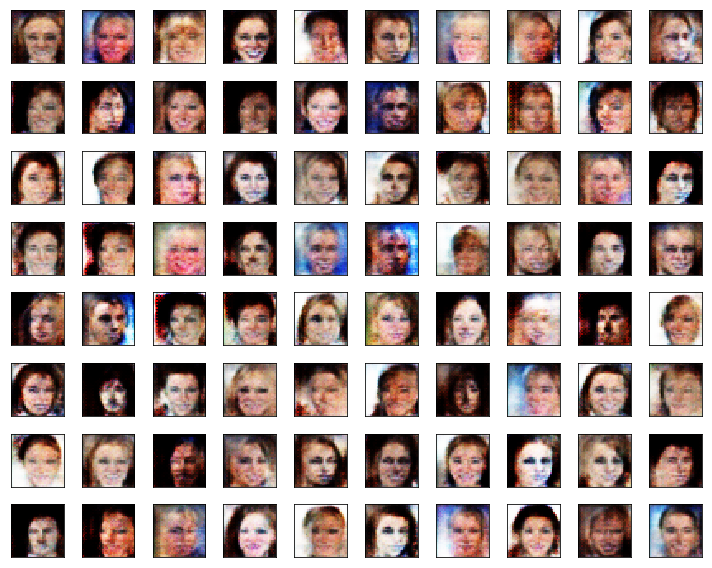

In [15]:
train(g_learning_rate=0.0001, 
      g_beta_1=0.5, 
      d_learning_rate=0.001, 
      d_beta_1=0.5, 
      leaky_alpha=0.2, 
      init_std=0.02);

### Training 2 Observations

* I see some faces but they are not very clear.
* In later epochs, the faces became blurly.
* The generator loss is unstable.
* The discriminator loss is higher than the training 1 but kind of stable.

### Training 3

I changed the beta_1 from 0.5 to 0.9.

100%|██████████| 1574/1574 [05:32<00:00,  4.55it/s]


Epoch:   1/5 Discriminator Loss: 0.0993 Generator Loss: 2.4188


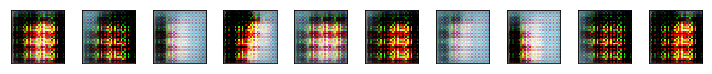

100%|██████████| 1574/1574 [05:23<00:00,  4.97it/s]


Epoch:   2/5 Discriminator Loss: 0.0706 Generator Loss: 2.8163


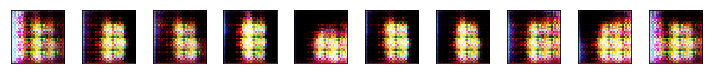

100%|██████████| 1574/1574 [05:18<00:00,  4.97it/s]


Epoch:   3/5 Discriminator Loss: 0.0576 Generator Loss: 3.0532


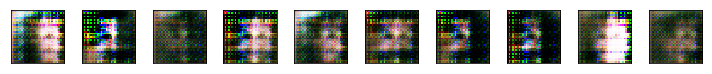

100%|██████████| 1574/1574 [05:17<00:00,  4.99it/s]


Epoch:   4/5 Discriminator Loss: 0.1657 Generator Loss: 1.9650


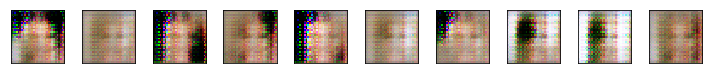

100%|██████████| 1574/1574 [05:19<00:00,  5.01it/s]


Epoch:   5/5 Discriminator Loss: 0.1127 Generator Loss: 2.5658


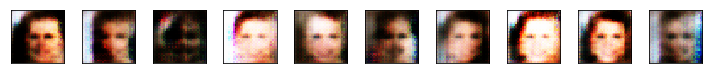

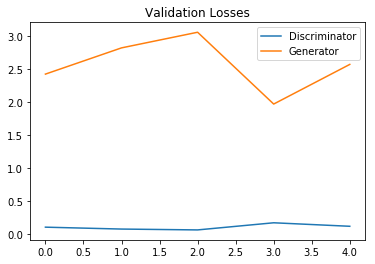

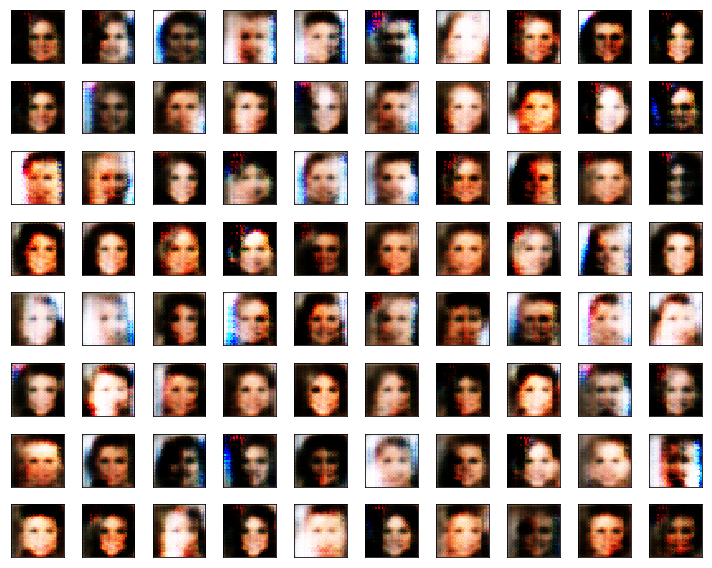

In [16]:
train(g_learning_rate=0.0001, 
      g_beta_1=0.9, 
      d_learning_rate=0.001, 
      d_beta_1=0.9, 
      leaky_alpha=0.2, 
      init_std=0.02);

### Training 3 Observations

* The generator loss is more stable than the training 2 but...
* Faces are not as clear as the training 2.
* Faces look all similar.
* beta_1 seems to have a big impact.

### Training 4

Let's use the same hyperparameters as in the training 2 with a bigger initialization standard deviation (hope this will bring more face variety).

100%|██████████| 1574/1574 [05:28<00:00,  4.83it/s]


Epoch:   1/5 Discriminator Loss: 0.0000 Generator Loss: 15.8622


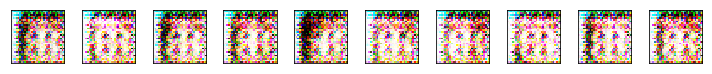

100%|██████████| 1574/1574 [05:29<00:00,  4.45it/s]


Epoch:   2/5 Discriminator Loss: 0.2037 Generator Loss: 2.1152


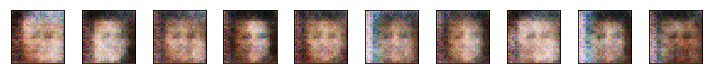

100%|██████████| 1574/1574 [05:24<00:00,  4.98it/s]


Epoch:   3/5 Discriminator Loss: 0.2184 Generator Loss: 1.9985


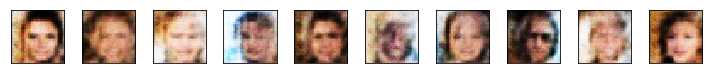

100%|██████████| 1574/1574 [05:28<00:00,  4.95it/s]


Epoch:   4/5 Discriminator Loss: 0.9018 Generator Loss: 0.5446


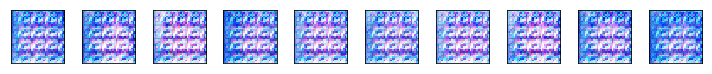

100%|██████████| 1574/1574 [05:23<00:00,  4.96it/s]


Epoch:   5/5 Discriminator Loss: 0.4221 Generator Loss: 1.1156


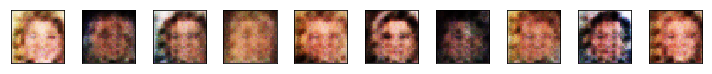

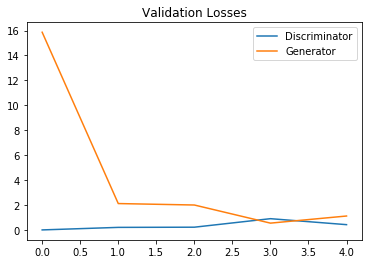

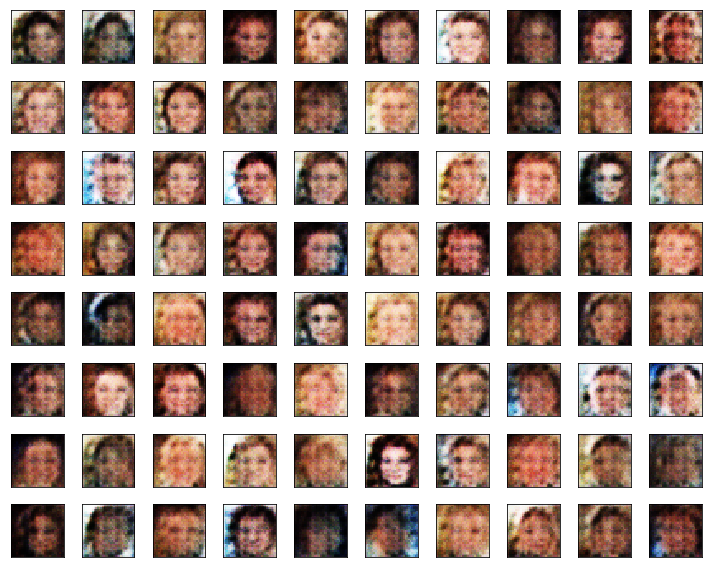

In [17]:
train(g_learning_rate=0.0001, 
      g_beta_1=0.5, 
      d_learning_rate=0.001, 
      d_beta_1=0.5, 
      leaky_alpha=0.2, 
      init_std=0.1);

### Training 4 Observations

* The faces are not very clear after all.

## Conclusion

* The training 2 generates the best faces.
* To improve the quality:
    * Experiment with more hyperparameters
    * Experiment with different network architectures for the generator and the discriminator 

## References

<a id="ref1"></a>
### [1] Large-scale CelebFaces Attributes (CelebA) Dataset

Ziwei Liu, Ping Luo, Xiaogang Wang, Xiaoou Tang
Multimedia Laboratory, The Chinese University of Hong Kong

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

<a id="ref2"></a>
### [2] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford & Luke Metz (indico Research), Soumith Chintala (Facebook AI Research)

https://arxiv.org/pdf/1511.06434.pdf

<a id="ref3"></a>
### [3] Face Generation Project (Deep Learning Foundactions)
Udacity

https://github.com/udacity/deep-learning/blob/master/face_generation/dlnd_face_generation.ipynb

This has no solution but it gives the structural idea and has the helper functions to download the CelebA dataset.